<h1 align="center">Clasificación con Regresión Logística en Conjunto de Datos Iris (UCI)</h1>
 

Este notebook aplica un modelo de regresión logística multiclase utilizando el conjunto de datos Iris. Se emplea la estrategia One-vs-Rest para clasificar las flores en tres categorías, usando métodos de optimización como el **descenso de gradiente** y **Newton-Raphson multivariable** (opcional).

## 1. Carga del Dataset

Cargamos el dataset `iris.data`, que contiene 150 muestras de flores clasificadas en tres especies. Cada muestra tiene cuatro características numéricas: largo y ancho del sépalo, y largo y ancho del pétalo.

In [17]:
import pandas as pd

# Cargar datos
columnas = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
df = pd.read_csv("iris.data", names=columnas)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 2. Exploración y Limpieza Inicial
Se realiza una inspección del dataset para entender su estructura, verificar valores faltantes o duplicados y visualizar su distribución mediante diagramas y gráficos de dispersión.

In [18]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## 3. Visualización de Datos

La visualización de datos es una parte clave del análisis exploratorio, ya que nos permite entender mejor la distribución, relación y comportamiento de las variables.Estas gráficas nos dan una primera impresión del comportamiento de los datos antes de aplicar modelos matemáticos, y nos ayudan a tomar decisiones sobre normalización, codificación o selección de variables.

Duplicados: 3


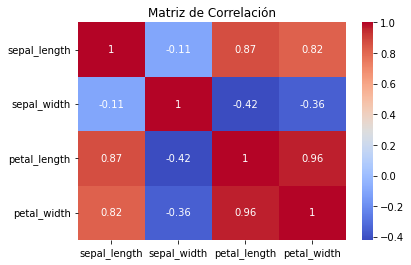

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Duplicados
print("Duplicados:", df.duplicated().sum())

# Correlación
sns.heatmap(df.drop(columns=["class"]).corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

### Conclusión 

La matriz nos muestra qué tan relacionadas están las variables numéricas entre sí. Podemos observar que `petal_length` y `petal_width` tienen una correlación muy alta (0.96), lo que indica que crecen juntas. En cambio, `sepal_width` tiene una correlación baja o negativa con otras variables, lo que sugiere que está menos relacionada.  
Esto nos ayuda a identificar qué variables aportan información similar y cuáles son más independientes para el análisis.


### Gráfico de Dispersión entre Variables por Clase
Se utiliza `pairplot` de Seaborn para observar la relación entre todas las variables, coloreadas por clase original.

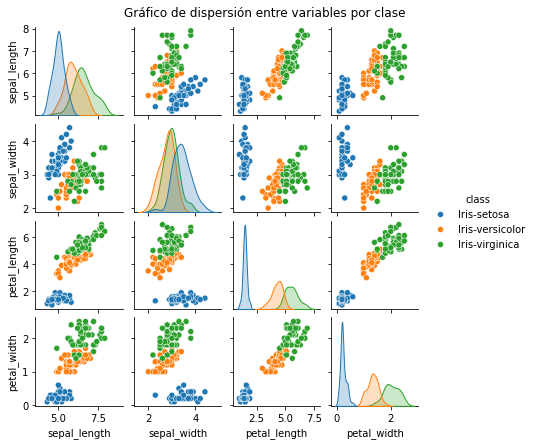

In [20]:
# Volvemos a cargar los datos incluyendo la columna original 'class'
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

columnas = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
df = pd.read_csv("iris.data", names=columnas)

sns.pairplot(df, hue='class', height=1.5)
plt.suptitle("Gráfico de dispersión entre variables por clase", y=1.02)
plt.show()

### Conclusión
El gráfico muestra cómo se relacionan las características de las flores según su especie. Podemos ver que las flores de diferente clase tienen formas y tamaños distintos, especialmente en los pétalos. Esto permite diferenciarlas fácilmente y confirma que los datos son útiles para entrenar modelos de clasificación.

## 4. Codificación de Variables Categóricas
Se aplica codificación One-Hot para transformar las clases categóricas en etiquetas numéricas.

In [21]:
from sklearn.preprocessing import LabelEncoder

# Convertir etiquetas
le = LabelEncoder()
df["label"] = le.fit_transform(df["class"])
df = df.drop(columns=["class"])

X = df.drop(columns=["label"]).values
y = df["label"].values


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 5. Modelo One-vs-Rest con Descenso de Gradiente
Se implementa regresión logística binaria para cada clase contra las demás.

### • División de Datos
Dividimos el conjunto de datos en subconjuntos de **entrenamiento y prueba** para evaluar el modelo. Además, estandarizamos las variables para que tengan media cero y varianza unitaria, lo cual mejora la convergencia del algoritmo.

$$X' = \frac{X - \mu}{\sigma}$$

In [23]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradient_descent(X, y, lr=0.1, epochs=1000):
    m, n = X.shape
    X = np.hstack((np.ones((m,1)), X))
    weights = np.zeros(n + 1)
    for _ in range(epochs):
        z = np.dot(X, weights)
        h = sigmoid(z)
        grad = np.dot(X.T, (h - y)) / m
        weights -= lr * grad
    return weights

def predict(X, weights):
    X = np.hstack((np.ones((X.shape[0],1)), X))
    return sigmoid(np.dot(X, weights))

# Entrenar One-vs-Rest
weights_all = []
for class_label in np.unique(y_train):
    y_binary = (y_train == class_label).astype(int)
    weights = gradient_descent(X_train, y_binary)
    weights_all.append(weights)

def predict_multiclass(X, weights_all):
    preds = np.array([predict(X, w) for w in weights_all]).T
    return np.argmax(preds, axis=1)

y_pred_gd = predict_multiclass(X_test, weights_all)

### • Evolución de la Función de Pérdida
Se puede visualizar la evolución de la función de pérdida logística durante el entrenamiento con descenso de gradiente.

La función de pérdida logística (log-loss) para un problema binario se define como:
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right]$$

donde:

$$
h_\theta(x) = \frac{1}{1 + e^{-x^T\theta}}
$$

A continuación, implementamos esta estrategia para el dataset de Iris.


Entrenando para la clase: 0
Última pérdida: 0.0312
Precisión del modelo: 100.00%

Entrenando para la clase: 1
Última pérdida: 0.5046
Precisión del modelo: 69.17%

Entrenando para la clase: 2
Última pérdida: 0.2108
Precisión del modelo: 95.00%


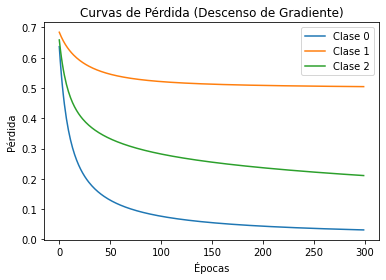

In [24]:
def compute_loss(X, y, weights): 
    m = len(y)
    X = np.hstack((np.ones((m,1)), X))
    h = sigmoid(X @ weights)
    epsilon = 1e-5 
    return -np.mean(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))

# Guardar historial de pérdida
losses = []
for class_label in np.unique(y_train):
    print(f"\nEntrenando para la clase: {class_label}")
    y_binary = (y_train == class_label).astype(int)
    m, n = X_train.shape
    X_aug = np.hstack((np.ones((m,1)), X_train))
    weights = np.zeros(n + 1)
    class_losses = []
    for _ in range(300):
        z = np.dot(X_aug, weights)
        h = sigmoid(z)
        grad = np.dot(X_aug.T, (h - y_binary)) / m
        weights -= 0.1 * grad
        class_losses.append(compute_loss(X_train, y_binary, weights))
    losses.append(class_losses)

    # Calcular y mostrar última pérdida y precisión
    final_loss = class_losses[-1]
    predictions = (sigmoid(X_aug @ weights) >= 0.5).astype(int)
    accuracy = np.mean(predictions == y_binary)
    print(f"Última pérdida: {final_loss:.4f}")
    print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Graficar curvas de pérdida
for i, l in enumerate(losses):
    plt.plot(l, label=f"Clase {i}")
plt.title("Curvas de Pérdida (Descenso de Gradiente)")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.show()


### Conclusión:  
El modelo muestra diferentes niveles de precisión dependiendo de la clase. Mientras que para algunas clases el rendimiento es alto, en otras es notablemente más bajo. Esto indica que el comportamiento del modelo varía según la categoría que intenta predecir.


## 6. Newton-Raphson Multivariable
Se implementa como alternativa al descenso de gradiente para minimizar la función logística.

In [25]:
def newton_raphson(X, y, iterations=10):
    m, n = X.shape
    X = np.hstack((np.ones((m,1)), X))
    weights = np.zeros(n + 1)
    for _ in range(iterations):
        z = X @ weights
        h = sigmoid(z)
        grad = X.T @ (h - y)
        H = X.T @ np.diag(h * (1 - h)) @ X
        weights -= np.linalg.inv(H) @ grad
    return weights

# Entrenar con NR
weights_all_nr = []
for class_label in np.unique(y_train):
    y_binary = (y_train == class_label).astype(int)
    weights = newton_raphson(X_train, y_binary)
    weights_all_nr.append(weights)

y_pred_nr = predict_multiclass(X_test, weights_all_nr)

## 7. Evaluación del Modelo
Se compara el desempeño de ambos métodos con métricas de precisión.

In [26]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Función para convertir el classification_report a DataFrame
def reporte_como_dataframe(y_true, y_pred):
    reporte = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(reporte).transpose()
    return df

# Resultados para Descenso de Gradiente
reporte_gd = reporte_como_dataframe(y_test, y_pred_gd)
accuracy_gd = accuracy_score(y_test, y_pred_gd)

# Resultados para Newton-Raphson
reporte_nr = reporte_como_dataframe(y_test, y_pred_nr)
accuracy_nr = accuracy_score(y_test, y_pred_nr)

# Mostrar con encabezados
print(f"Accuracy (Descenso de Gradiente): {accuracy_gd:.4f}")

print(f"\nAccuracy (Newton-Raphson): {accuracy_nr:.4f}")



Accuracy (Descenso de Gradiente): 0.9667

Accuracy (Newton-Raphson): 1.0000


### Conclusión 
Al aplicar el método de descenso de gradiente en un modelo de regresión logística multiclase usando la estrategia One-vs-Rest sobre el conjunto de datos Iris, se obtuvo una precisión del 96.67%.
Este resultado indica que el modelo fue capaz de clasificar correctamente la mayoría de las flores, lo cual demuestra que el descenso de gradiente es una técnica eficaz y adecuada para este tipo de problema de clasificación. Ahora bien, agregamos el método de Newton-Raphson como opcional si observamos al menos en este caso, Newton-Raphson es más eficaz que el descenso de gradiente para entrenar modelos de regresión logística multiclase.